In [24]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [26]:
training_labels = pd.read_csv('../data/training set labels.csv')
training_value_data = pd.read_csv('../data/training set values.csv')

In [28]:
# Merge data
df = pd.merge(training_value_data, training_labels, on='id', how='inner')

important_features = [
    'quantity', 'quantity_group', 'lga', 'construction_year', 'region_code',
    'extraction_type_class', 'waterpoint_type', 'region', 'gps_height',
    'waterpoint_type_group', 'installer', 'source', 'payment_type',
    'amount_tsh', 'basin', 'status_group'  # termasuk target
]

# Filter hanya fitur penting
df_important = df[important_features].copy()

In [30]:
def preprocess_important_data(df, is_training=True):
    """
    Preprocess data dengan hanya 15 fitur penting
    """
    # Handle missing values
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Isi missing values
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    df[categorical_cols] = df[categorical_cols].fillna('unknown')
    
    # Label encoding untuk categorical features
    label_mappings = {}
    categorical_features = []
    
    for col in categorical_cols:
        if col != "status_group":
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
            categorical_features.append(col)
    
    # Standard scaling untuk numerical features
    scaler = StandardScaler()
    numerical_features = numerical_cols.tolist()
    if numerical_features:  # hanya jika ada numerical features
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode target variable jika dalam mode training
    if is_training and 'status_group' in df.columns:
        conditions = [
            (df['status_group'] == "functional"),
            (df['status_group'] == "non functional"),
            (df['status_group'] == "functional needs repair")
        ]
        values = [1, 0, 2]
        df['Operation'] = np.select(conditions, values)
        df = df.drop(['status_group'], axis=1)
    
    return df, label_mappings, scaler, numerical_features, categorical_features

# Preprocess data dengan fitur penting
print("Shape sebelum feature selection:", df.shape)
print("Shape setelah feature selection:", df_important.shape)

processed_df, label_mappings, scaler, numerical_cols, categorical_cols = preprocess_important_data(df_important)

Shape sebelum feature selection: (59400, 41)
Shape setelah feature selection: (59400, 16)


In [32]:
# Simpan kolom yang digunakan (tanpa target)
used_columns = [col for col in processed_df.columns if col != 'Operation']

print("Fitur yang digunakan:", used_columns)
print("Jumlah fitur:", len(used_columns))
print("Fitur kategorikal:", categorical_cols)
print("Fitur numerik:", numerical_cols)

# Split data
X = processed_df.drop('Operation', axis=1)
y = processed_df['Operation']

# Handle class imbalance dengan SMOTE
print("\nSebelum SMOTE - Distribusi kelas:", np.bincount(y))
smt = SMOTE(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print("Setelah SMOTE - Distribusi kelas:", np.bincount(y_res))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

Fitur yang digunakan: ['quantity', 'quantity_group', 'lga', 'construction_year', 'region_code', 'extraction_type_class', 'waterpoint_type', 'region', 'gps_height', 'waterpoint_type_group', 'installer', 'source', 'payment_type', 'amount_tsh', 'basin']
Jumlah fitur: 15
Fitur kategorikal: ['quantity', 'quantity_group', 'lga', 'extraction_type_class', 'waterpoint_type', 'region', 'waterpoint_type_group', 'installer', 'source', 'payment_type', 'basin']
Fitur numerik: ['construction_year', 'region_code', 'gps_height', 'amount_tsh']

Sebelum SMOTE - Distribusi kelas: [22824 32259  4317]
Setelah SMOTE - Distribusi kelas: [32259 32259 32259]


In [34]:
# Train model dengan hyperparameter yang dioptimalkan
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print("\nTraining model dengan 15 fitur penting...")
rf_model.fit(X_train, y_train)

# Evaluasi
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n=== HASIL MODEL DENGAN 15 FITUR PENTING ===")
print(f"Akurasi: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training model dengan 15 fitur penting...

=== HASIL MODEL DENGAN 15 FITUR PENTING ===
Akurasi: 0.8108

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      6452
           1       0.78      0.76      0.77      6452
           2       0.80      0.91      0.85      6452

    accuracy                           0.81     19356
   macro avg       0.81      0.81      0.81     19356
weighted avg       0.81      0.81      0.81     19356



In [35]:
# Simpan model dan preprocessor
preprocessor = {
    'used_columns': used_columns,
    'label_mappings': label_mappings,
    'scaler': scaler,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols
}

# Simpan ke file
joblib.dump(rf_model, 'random_forest_model.pkl', compress=('xz', 3))
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Model dan preprocessor berhasil disimpan!")
print("Kolom kategorikal:", categorical_cols)
print("Kolom numerik:", numerical_cols)
print("Semua kolom yang digunakan:", used_columns)

Model dan preprocessor berhasil disimpan!
Kolom kategorikal: ['quantity', 'quantity_group', 'lga', 'extraction_type_class', 'waterpoint_type', 'region', 'waterpoint_type_group', 'installer', 'source', 'payment_type', 'basin']
Kolom numerik: ['construction_year', 'region_code', 'gps_height', 'amount_tsh']
Semua kolom yang digunakan: ['quantity', 'quantity_group', 'lga', 'construction_year', 'region_code', 'extraction_type_class', 'waterpoint_type', 'region', 'gps_height', 'waterpoint_type_group', 'installer', 'source', 'payment_type', 'amount_tsh', 'basin']


Minimum and Maximum Values for Selected Numerical Columns:


,Column,Min Value,Max Value
region_code,region_code,1.0,99.0
construction_year,construction_year,0.0,2013.0
amount_tsh,amount_tsh,0.0,350000.0
gps_height,gps_height,-90.0,2770.0
population,population,0.0,30500.0



Minimum and Maximum Values by Pump Status:

Status: functional


,Column,Min (functional),Max (functional)
region_code,region_code,1.0,99.0
construction_year,construction_year,0.0,2013.0
amount_tsh,amount_tsh,0.0,350000.0
gps_height,gps_height,-90.0,2628.0
population,population,0.0,30500.0



Status: non functional


,Column,Min (non functional),Max (non functional)
region_code,region_code,1.0,99.0
construction_year,construction_year,0.0,2013.0
amount_tsh,amount_tsh,0.0,117000.0
gps_height,gps_height,-59.0,2627.0
population,population,0.0,9865.0



Status: functional needs repair


,Column,Min (functional needs repair),Max (functional needs repair)
region_code,region_code,1.0,99.0
construction_year,construction_year,0.0,2013.0
amount_tsh,amount_tsh,0.0,100000.0
gps_height,gps_height,-51.0,2770.0
population,population,0.0,15300.0


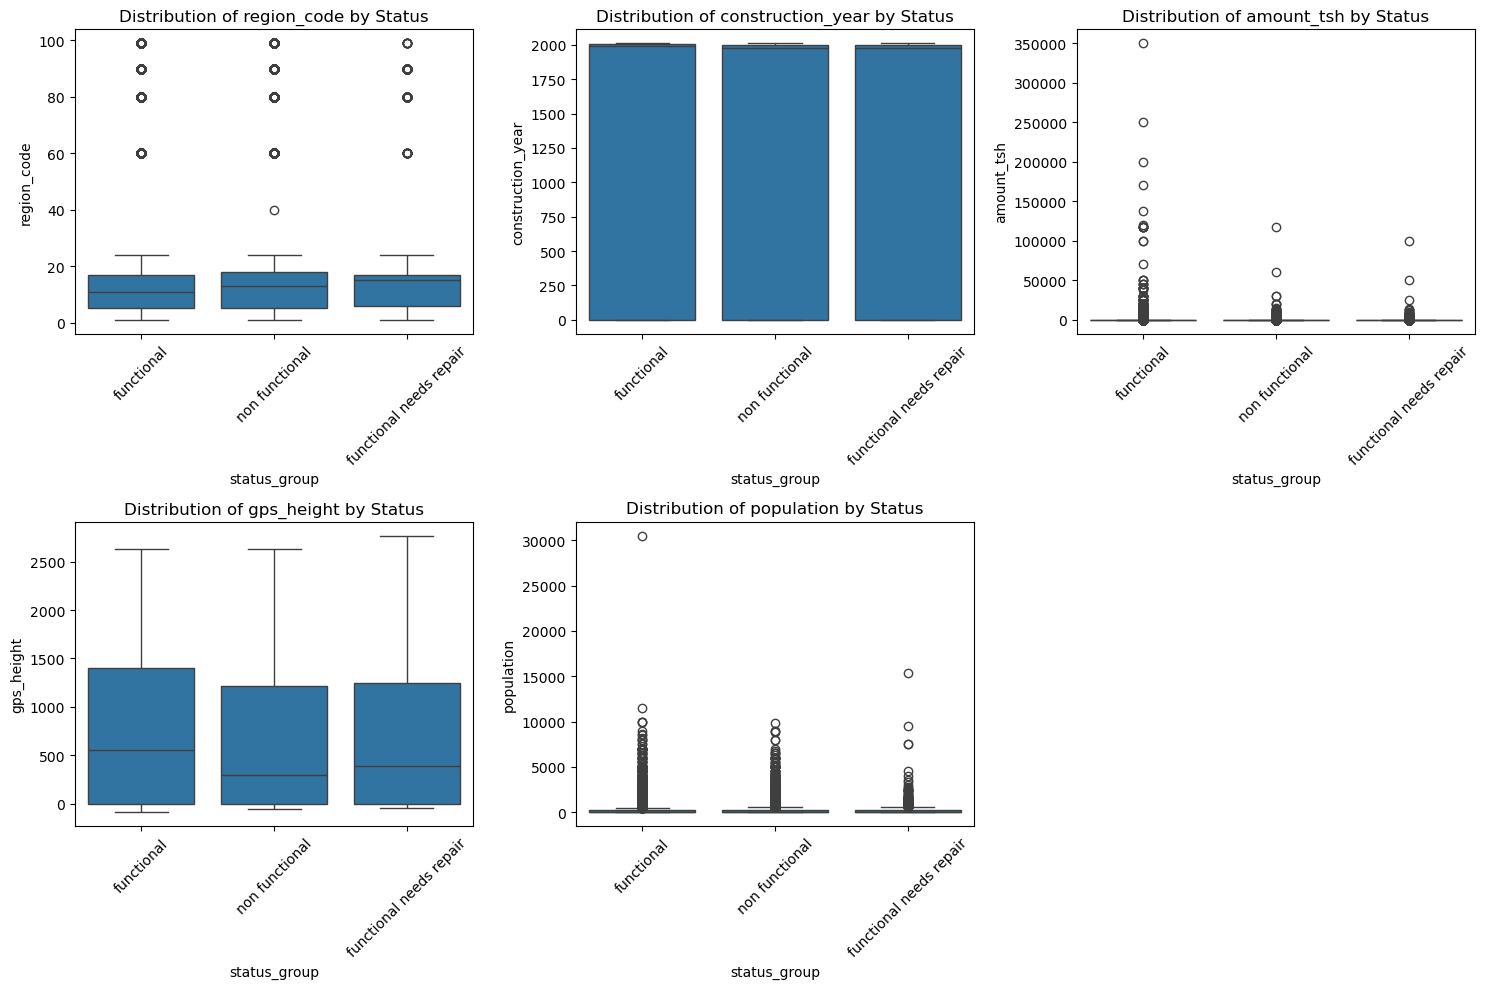


Descriptive Statistics for Numerical Columns:


,region_code,construction_year,amount_tsh,gps_height,population
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,15.297003,1300.652475,317.650385,668.297239,179.909983
std,17.587406,951.620547,2997.574558,693.116350,471.482176
min,1.000000,0.000000,0.000000,-90.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,1986.000000,0.000000,369.000000,25.000000
75%,17.000000,2004.000000,20.000000,1319.250000,215.000000
max,99.000000,2013.000000,350000.000000,2770.000000,30500.000000


In [38]:
numerical_cols = ['region_code', 'construction_year', 'amount_tsh', 'gps_height', 'population']

# Calculate min and max values for each column
min_max_values = pd.DataFrame({
    'Column': numerical_cols,
    'Min Value': df[numerical_cols].min(),
    'Max Value': df[numerical_cols].max()
})

# Display the results
print("Minimum and Maximum Values for Selected Numerical Columns:")
display(min_max_values)

# Additional analysis: Min/Max by pump status
print("\nMinimum and Maximum Values by Pump Status:")

for status in ['functional', 'non functional', 'functional needs repair']:
    status_df = df[df['status_group'] == status]
    min_max_status = pd.DataFrame({
        'Column': numerical_cols,
        f'Min ({status})': status_df[numerical_cols].min(),
        f'Max ({status})': status_df[numerical_cols].max()
    })
    print(f"\nStatus: {status}")
    display(min_max_status)

# Visualization of distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='status_group', y=col)
    plt.title(f'Distribution of {col} by Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Basic statistics summary
print("\nDescriptive Statistics for Numerical Columns:")
display(df[numerical_cols].describe())

In [40]:
# Continue your notebook analysis after model training

# Get the top 5 important features
top_features = ['quantity_group', 'quantity', 'lga', 'construction_year', 'gps_height']

# Analyze each feature by status group
status_groups = df['status_group'].unique()
results = {}

for status in status_groups:
    status_df = df[df['status_group'] == status]
    feature_stats = {}
    
    # quantity_group - top 2 most frequent
    if 'quantity_group' in status_df.columns:
        top_quantity_groups = status_df['quantity_group'].value_counts().head(3).index.tolist()
        feature_stats['quantity_group'] = top_quantity_groups
    
    # quantity - top 2 most frequent
    if 'quantity' in status_df.columns:
        top_quantities = status_df['quantity'].value_counts().head(3).index.tolist()
        feature_stats['quantity'] = top_quantities
    
    # lga - top 2 most frequent (since it's categorical)
    if 'lga' in status_df.columns:
        top_lgas = status_df['lga'].value_counts().head(3).index.tolist()
        feature_stats['lga'] = top_lgas
    
    # construction_year - top 2 most frequent
    if 'construction_year' in status_df.columns:
        top_years = status_df['construction_year'].value_counts().head(3).index.tolist()
        feature_stats['construction_year'] = top_years
    
    # gps_height - average (only if numeric)
    if 'gps_height' in status_df.columns:
        if pd.api.types.is_numeric_dtype(status_df['gps_height']):
            avg_gps = status_df['gps_height'].mean()
            feature_stats['gps_height'] = round(avg_gps, 2)
        else:
            feature_stats['gps_height'] = "Non-numeric data"
    
    results[status] = feature_stats

# Display results
for status, stats in results.items():
    print(f"\nStatus Group: {status}")
    print("----------------------")
    for feature, value in stats.items():
        print(f"{feature}: {value}")


Status Group: functional
----------------------
quantity_group: ['enough', 'insufficient', 'seasonal']
quantity: ['enough', 'insufficient', 'seasonal']
lga: ['Njombe', 'Arusha Rural', 'Moshi Rural']
construction_year: [0, 2010, 2008]
gps_height: 740.13

Status Group: non functional
----------------------
quantity_group: ['enough', 'dry', 'insufficient']
quantity: ['enough', 'dry', 'insufficient']
lga: ['Mbozi', 'Singida Rural', 'Kyela']
construction_year: [0, 2000, 2008]
gps_height: 574.46

Status Group: functional needs repair
----------------------
quantity_group: ['enough', 'insufficient', 'seasonal']
quantity: ['enough', 'insufficient', 'seasonal']
lga: ['Bariadi', 'Kigoma Rural', 'Kasulu']
construction_year: [0, 2009, 2000]
gps_height: 627.61


In [46]:
import pandas as pd

# --- 1️⃣ Cek kombinasi unik untuk setiap pasangan fitur ---
def check_redundancy(df, col_a, col_b):
    combo = df[[col_a, col_b]].drop_duplicates()
    count_a = combo[col_a].nunique()
    count_b = combo[col_b].nunique()
    
    # Hitung apakah satu nilai di kolom A hanya punya satu nilai di kolom B
    mapping_unique = combo.groupby(col_a)[col_b].nunique()
    redundant_a_to_b = (mapping_unique == 1).all()
    
    mapping_unique_rev = combo.groupby(col_b)[col_a].nunique()
    redundant_b_to_a = (mapping_unique_rev == 1).all()
    
    print(f"\n🔍 Pair: {col_a} ↔ {col_b}")
    print(f"Jumlah kombinasi unik: {len(combo)}")
    print(f"{col_a} unik: {count_a}, {col_b} unik: {count_b}")
    
    if redundant_a_to_b and redundant_b_to_a:
        print(f"✅ PERFECT REDUNDANT: {col_a} dan {col_b} saling 1-to-1")
    elif redundant_a_to_b:
        print(f"⚠️ {col_a} menentukan {col_b} (1-to-1 dari kiri ke kanan)")
    elif redundant_b_to_a:
        print(f"⚠️ {col_b} menentukan {col_a} (1-to-1 dari kanan ke kiri)")
    else:
        print(f"❌ Tidak redundant: keduanya memiliki relasi banyak-ke-banyak")
    
    # Tampilkan 5 contoh kombinasi
    print(combo.head())

# --- 2️⃣ Uji ketiga pasangan ---
check_redundancy(df, 'quantity', 'quantity_group')
check_redundancy(df, 'region', 'region_code')
check_redundancy(df, 'waterpoint_type', 'waterpoint_type_group')

# --- 3️⃣ (Opsional) Cek korelasi kategorikal menggunakan Cramér’s V ---
import numpy as np
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("\n🔗 Cramér’s V (0 = tidak terkait, 1 = sangat kuat):")
print("quantity ↔ quantity_group :", round(cramers_v(df['quantity'], df['quantity_group']), 3))
print("region ↔ region_code :", round(cramers_v(df['region'], df['region_code']), 3))
print("waterpoint_type ↔ waterpoint_type_group :", round(cramers_v(df['waterpoint_type'], df['waterpoint_type_group']), 3))



🔍 Pair: quantity ↔ quantity_group
Jumlah kombinasi unik: 5
quantity unik: 5, quantity_group unik: 5
✅ PERFECT REDUNDANT: quantity dan quantity_group saling 1-to-1
        quantity quantity_group
0         enough         enough
1   insufficient   insufficient
3            dry            dry
4       seasonal       seasonal
21       unknown        unknown

🔍 Pair: region ↔ region_code
Jumlah kombinasi unik: 32
region unik: 21, region_code unik: 27
❌ Tidak redundant: keduanya memiliki relasi banyak-ke-banyak
    region  region_code
0   Iringa           11
1     Mara           20
2  Manyara           21
3   Mtwara           90
4   Kagera           18

🔍 Pair: waterpoint_type ↔ waterpoint_type_group
Jumlah kombinasi unik: 7
waterpoint_type unik: 7, waterpoint_type_group unik: 6
⚠️ waterpoint_type menentukan waterpoint_type_group (1-to-1 dari kiri ke kanan)
                waterpoint_type waterpoint_type_group
0            communal standpipe    communal standpipe
2   communal standpipe multi